# **In Class Participation Analysis**

Our method to pass the phase 1:


*   Comparing all the attendance list with zoom interaction (loads all students on 7th grade) --> count the correlation and evaluate the data

disclaimer:
1. mixpanel data are only available for students who joined to the session (624 unique sessions, 775 unique users and 5 undefined users & sessions)
2. metabase consists 453 unique sessions and 1011 unique users.
3. of 624 unique sessions and 775 unique users from mixpanel data, 177 unique sessions and 25 unique users **were not available** in metabase.
4. of 453 unique sessions from metabase data, 5 sessions **were undefined** in mixpanel.
4. as we observed, Grade breakdown in mixpanel is Student Grade not Course Grade. So, 177 unique sessions were eligible for other Course Grades (not 7th grade)
5. the conclusion, we will analysis 448 unique sessions and 750 unique users to get the correlation of their participation to attendance

In [61]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [62]:
#importing the data set
attendance_list = pd.read_csv('/content/drive/MyDrive/Participation/attendance_list_for_participation_2024-03-22T01_07_27.691227Z.csv')
zoom_interaction = pd.read_csv('/content/drive/MyDrive/Participation/zoom_interaction_mixpanel.csv')
in_class_assessment = pd.read_csv('/content/drive/MyDrive/Participation/in_class_assessment.csv')

zoom_interaction.rename(columns={'sessionId': 'session_id', '$user_id':'user_id', 'Grade':'grade', '(2) zoom audio on': 'audio_on', '(3) zoom video on': 'video_on','(4) zoom raise hand':'raised_hand','(5) private-zoom chat msg sent':'private_chat','(6) public-zoom chat msg sent':'public_chat'}, inplace= True)

In [63]:
#cleansing up the zoom interaction
columns_to_check = ['session_id', 'grade', 'user_id']

filtered_zoom_interaction = zoom_interaction[~zoom_interaction[columns_to_check].apply(lambda x: x.str.contains('overall')).any(axis=1) & ~zoom_interaction['user_id'].str.contains('undefined')]


In [64]:
#unique students from mixpanel
get_unique_students_zoom = filtered_zoom_interaction['user_id'].unique()

filtered_attendance_list = attendance_list[attendance_list['user_id'].isin(get_unique_students_zoom)]
filtered_in_class_assessment = in_class_assessment[in_class_assessment['user_id'].isin(get_unique_students_zoom)]

In [66]:
formative_assessment = filtered_in_class_assessment[filtered_in_class_assessment['assessment_type'].str.contains('formative')].rename(columns={'correct_answer':'formative_type'})
summative_assessment = filtered_in_class_assessment[filtered_in_class_assessment['assessment_type'].str.contains('summative')].rename(columns={'correct_answer':'summative_type'})

cols_assessment_type = [formative_assessment, summative_assessment]
cols_which_wants_to_drop = ['course_grades','start_date','assessment_type']

for type in cols_assessment_type:
    type.drop(columns=cols_which_wants_to_drop, inplace=True)

In [67]:
join_df = pd.merge(filtered_attendance_list,
                   filtered_zoom_interaction,
                   on=['session_id', 'user_id'],
                   how='left')

# Merge the result with formative_assessment
join_df = pd.merge(join_df,
                   formative_assessment,
                   on=['session_id', 'user_id'],
                   how='left')

# Merge the result with summative_assessment
join_df = pd.merge(join_df,
                   summative_assessment,
                   on=['session_id', 'user_id'],
                   how='left')

join_df.drop(columns=['grade','(1) live class joined'],inplace=True)
join_df.fillna(0, inplace=True)

# **Data Preprocessing**

In [54]:
#this for knowing how much the records and the cols
join_df.shape

(34253, 12)

**1. Checking missing value**

In [53]:
join_df.isna().sum()

session_id        0
user_id           0
start_date        0
course_grades     0
participated      0
audio_on          0
video_on          0
raised_hand       0
private_chat      0
public_chat       0
formative_type    0
summative_type    0
dtype: int64

**conclusion:** the data set does not have missing value

**2. Checking duplicate rows**

In [55]:
join_df.duplicated().any()

False

**conclusion:** the dataset does not have duplicate rows

# **Exploratory Data Analysis**

**1. Distribution of the target variable**

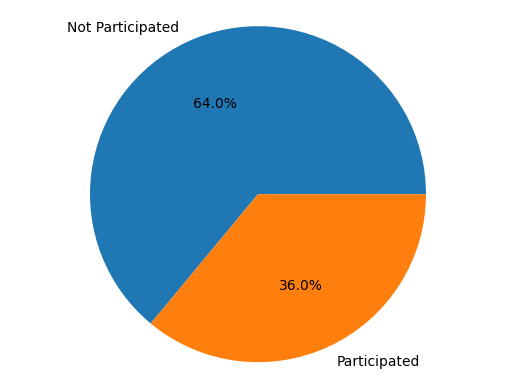

In [80]:
plt.pie(join_df['participated'].value_counts(), labels=['Not Participated', 'Participated'], autopct='%1.1f%%')
plt.axis('equal')
plt.show()

**conclusion:** in our case, where "Not Participated" accounts for 63% of the data and "Participated" accounts for the remaining 37%, this indicates a class imbalance where the "Not Participated" class is the majority class.

**2. How Participated are related with other variables**

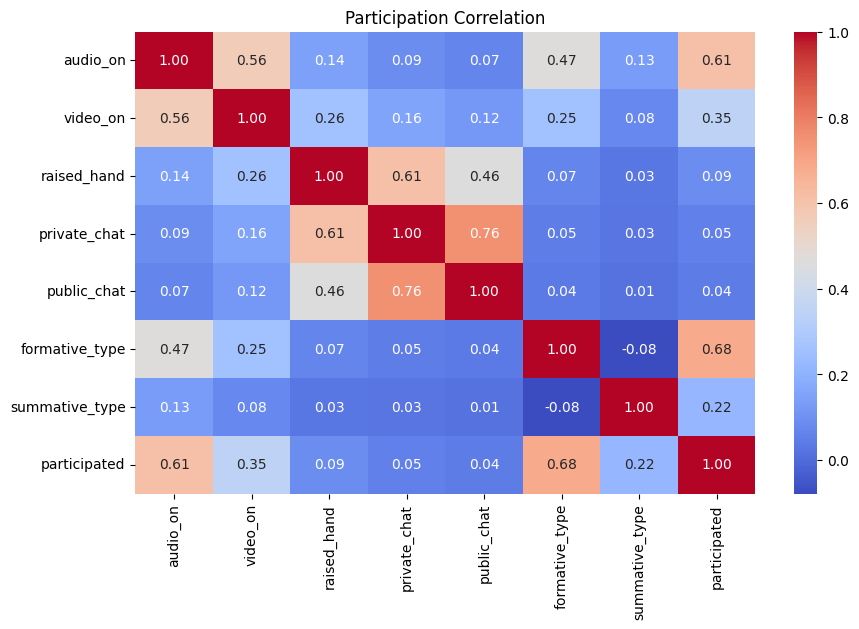

In [75]:
plt.figure(figsize=(10, 6))
sns.heatmap(join_df[['audio_on', 'video_on', 'raised_hand', 'private_chat', 'public_chat', 'formative_type', 'summative_type', 'participated']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Participation Correlation')
plt.show()

**conclusion:** audio_on and formative_type have more than 0.5. It means, they seem to be the most correlated with participated in class.

# **Model Building**

Due to our data only in between 1 or 0, we can use logistic regression model to find out the regression rather than linier regression (for continuous data)

In the context of logistic regression, the R^2
  statistic, often used in linear regression, isn't typically used to evaluate model performance. R^2
  (also known as the coefficient of determination) measures the proportion of the variance in the dependent variable that is predictable from the independent variables in linear regression. For logistic regression, however, this measure doesn't quite fit because logistic regression deals with probabilities and classifications, not continuous outputs.

Instead, for evaluating logistic regression models, metrics such as accuracy, precision, recall (sensitivity), and the F1 score are more appropriate and commonly used. Here's what each represents:

1. Accuracy: This measures the overall correctness of the model and is calculated as the ratio of correctly predicted observations to the total observations. It's useful when the target classes are well balanced.
2. Precision: Indicates the accuracy of positive predictions. This metric is particularly important when the cost of a false positive is high.
3. Recall (Sensitivity): Measures the ability of the model to capture available positives. It's crucial when the cost of missing a positive (false negative) is high.
4. F1 Score: Harmonic mean of precision and recall. It's a good measure when you need to balance precision and recall, especially if there's an uneven class distribution.

In our case, considering you are working with a classification problem where the outcome variable is binary, using these metrics (accuracy, precision, recall, and F1 score) will provide a comprehensive view of your model's performance

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Prepare Data
X = join_df[['audio_on', 'video_on', 'raised_hand', 'private_chat', 'public_chat', 'formative_type']]  # Independent variables
y = join_df['participated']  # Dependent variable (binary)

# Step 2: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Train the Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 4: Predictions
y_pred = model.predict(X_test)

# Step 5: Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.9304203970416505
Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      6639
           1       1.00      0.80      0.89      3637

    accuracy                           0.93     10276
   macro avg       0.95      0.90      0.92     10276
weighted avg       0.94      0.93      0.93     10276



based on Accuracy value, the model is overall good around 94,7%. For Precision, Class 1 has 1.00, it means that every model predicts Class 1 is almost true. For Recall, Class 1 has 0.85, where the model can identify 85% of the actual case in Class 1. For F1-score, This measures balance between precision and recall. Once we have high F1-score, the model has good precision and recall. It's not perfect model, since the recall metric is lower than precision.

In conclusion, our model does an excellent job predicting class 0 but is slightly less effective for class 1, particularly in terms of finding all actual positive cases (as shown by the lower recall).